In [1]:
from localgraphclustering import *

import time
import numpy as np

# Import the graph_tool module for visualization.
from graph_tool.all import * 

# Import matplotlib 
import matplotlib.pyplot as plt

# Just a useful function.
def diff(a, b):
        b = set(b)
        return np.asarray([aa for aa in a if aa not in b], dtype = 'int64')

# Load graph for localgraphclustering package

In [2]:
# Read graph. This also supports gml format.
g = GraphLocal('./datasets/JohnsHopkins.graphml','graphml','\t')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:203: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



# Load graph using graph-tool in order to extract graph attributes as well.

In [3]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/JohnsHopkins.graphml")
    
remove_self_loops(g_gtool)

# Load coordinates for visualization

In [4]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]

# Extract "ground truth" cluster, i.e., nodes with majorIndex 217

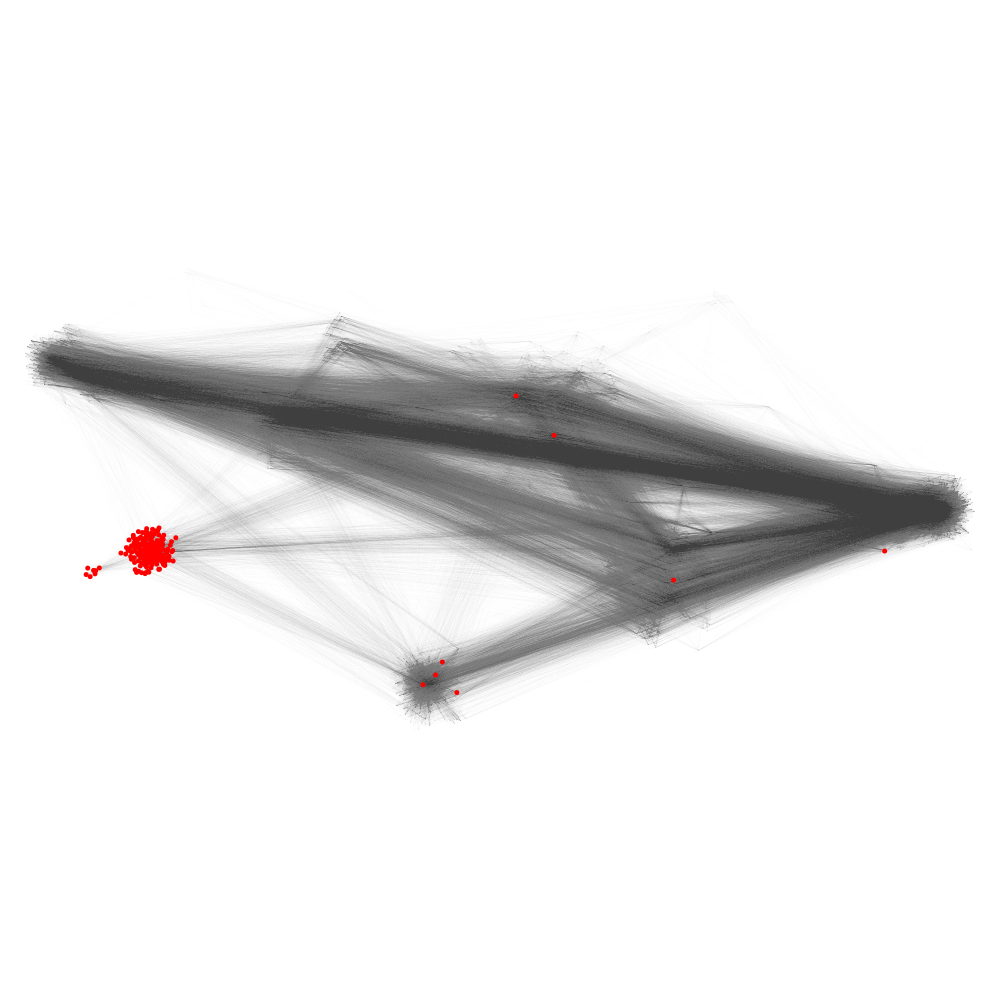

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14ca70d30, at 0x10afd5b70>

In [5]:
# For details about the "ground truth" cluster please refer to: D. Wang, K. Fountoulakis, M. Henzinger, 
# M. Mahoney and S. Rao. Capacity Releasing Diffusion for Speed and Locality. ICML 2017.

g_gtool_majorIndex = g_gtool.vertex_properties.majorIndex

majorIndex_217_students = []
for i in range(g._num_vertices):
    if g_gtool_majorIndex[i] == 217.0:
        majorIndex_217_students.append(i)
        
# Visualize students of dorm 217.
temp = np.zeros(g._num_vertices) + 0.00001

temp[majorIndex_217_students] = 5

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in majorIndex_217_students:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)  

c_map = plt.get_cmap('autumn')
    
graph_draw(g_gtool, pos, output_size=(1000, 1000),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap=c_map)

# Run flow-based algorithm Capacity Releasing Diffusion

CRD iteration:  1
precision: 1.0
recall:  0.008413573899224081
Conductance: 1.0
Conductance ground truth: 0.2624100215013555


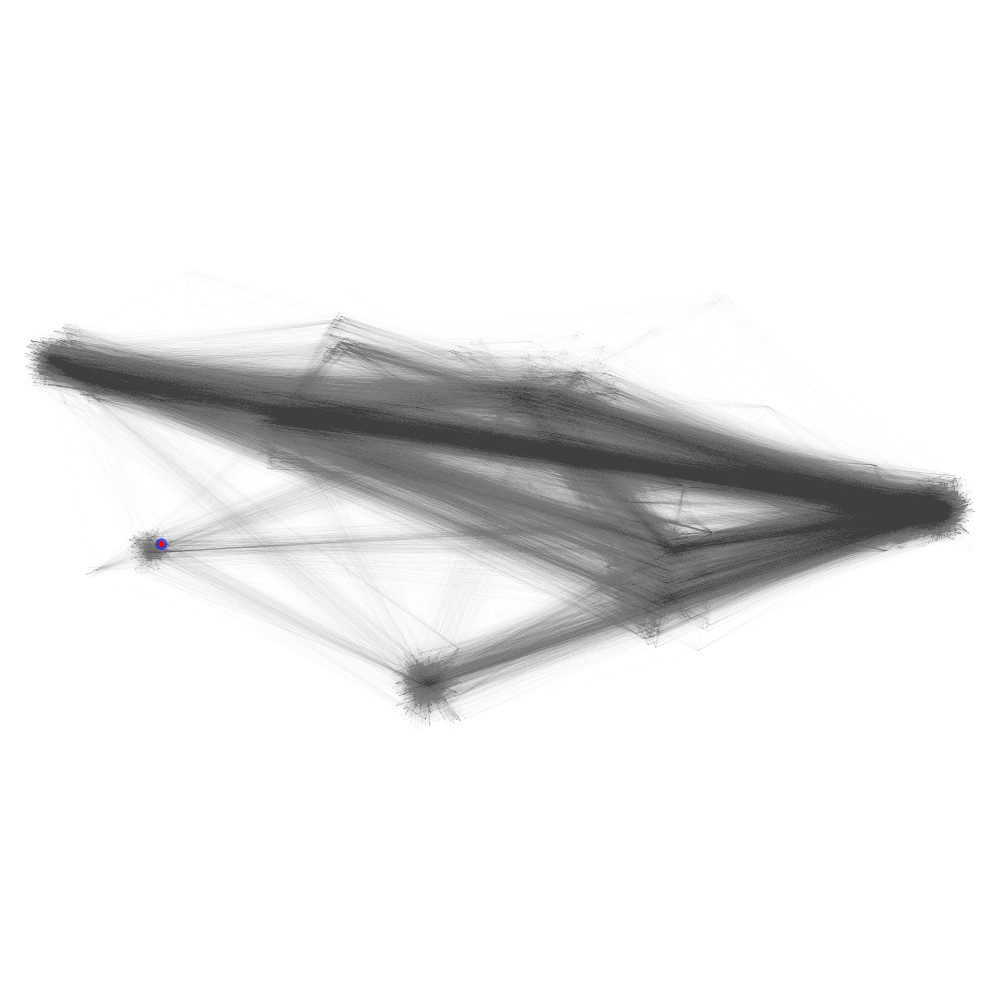

CRD iteration:  2
precision: 1.0
recall:  0.008413573899224081
Conductance: 1.0
Conductance ground truth: 0.2624100215013555


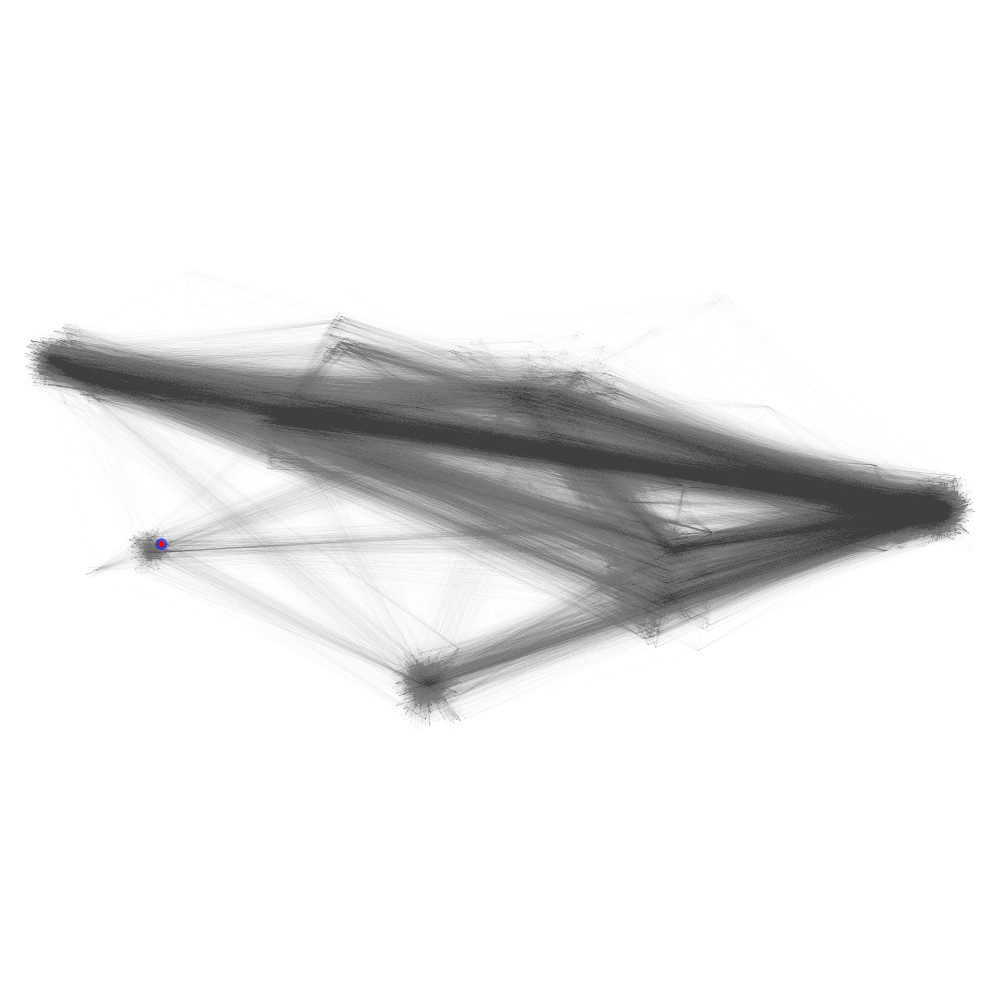

CRD iteration:  3
precision: 1.0
recall:  0.009161447134710666
Conductance: 0.9591836734693877
Conductance ground truth: 0.2624100215013555


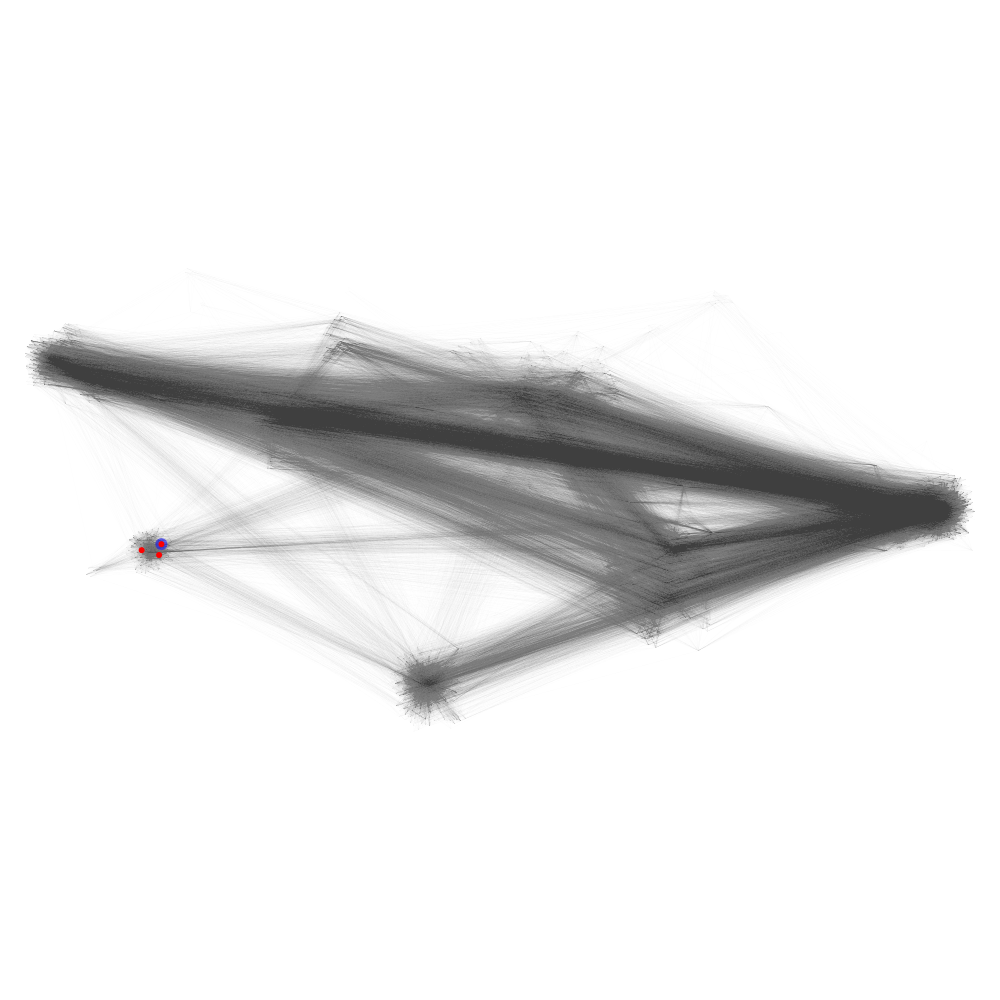

CRD iteration:  4
precision: 0.918918918918919
recall:  0.01589230625408993
Conductance: 0.8810810810810811
Conductance ground truth: 0.2624100215013555


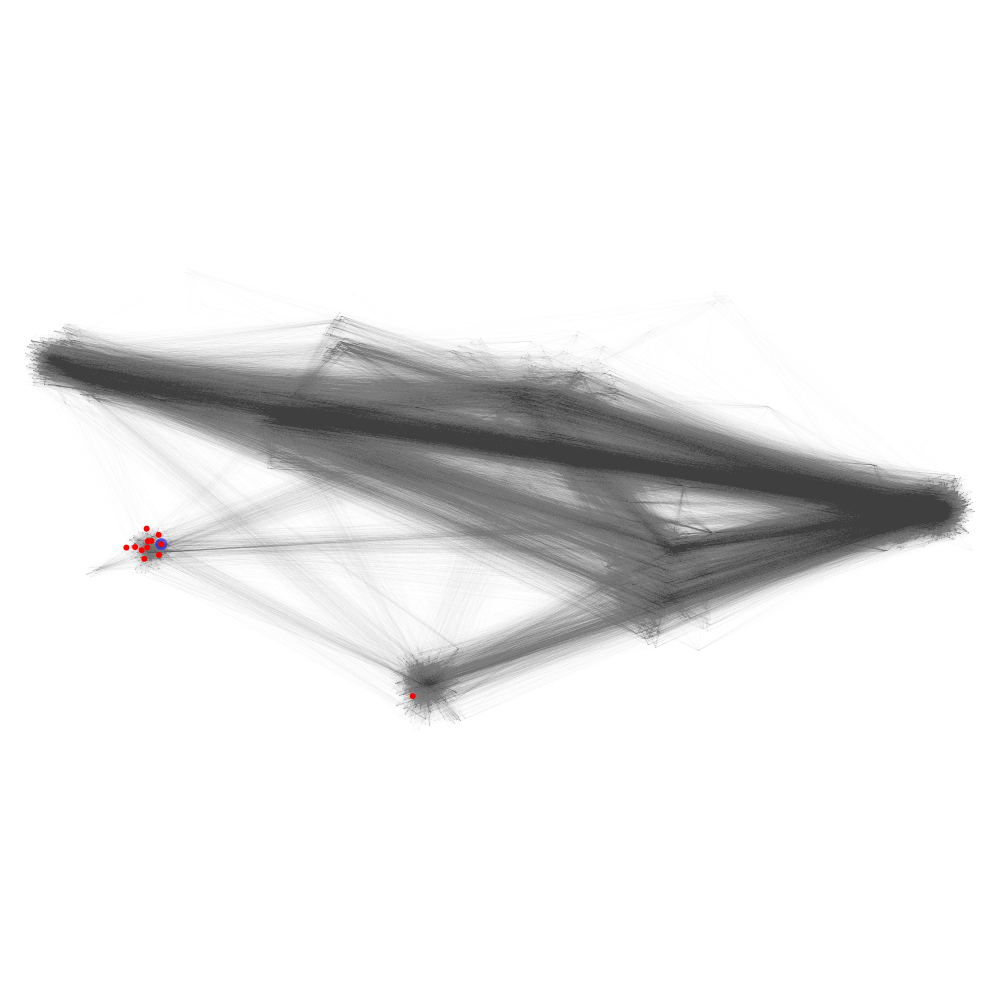

CRD iteration:  5
precision: 0.7805232558139535
recall:  0.05020099093203702
Conductance: 0.7645348837209303
Conductance ground truth: 0.2624100215013555


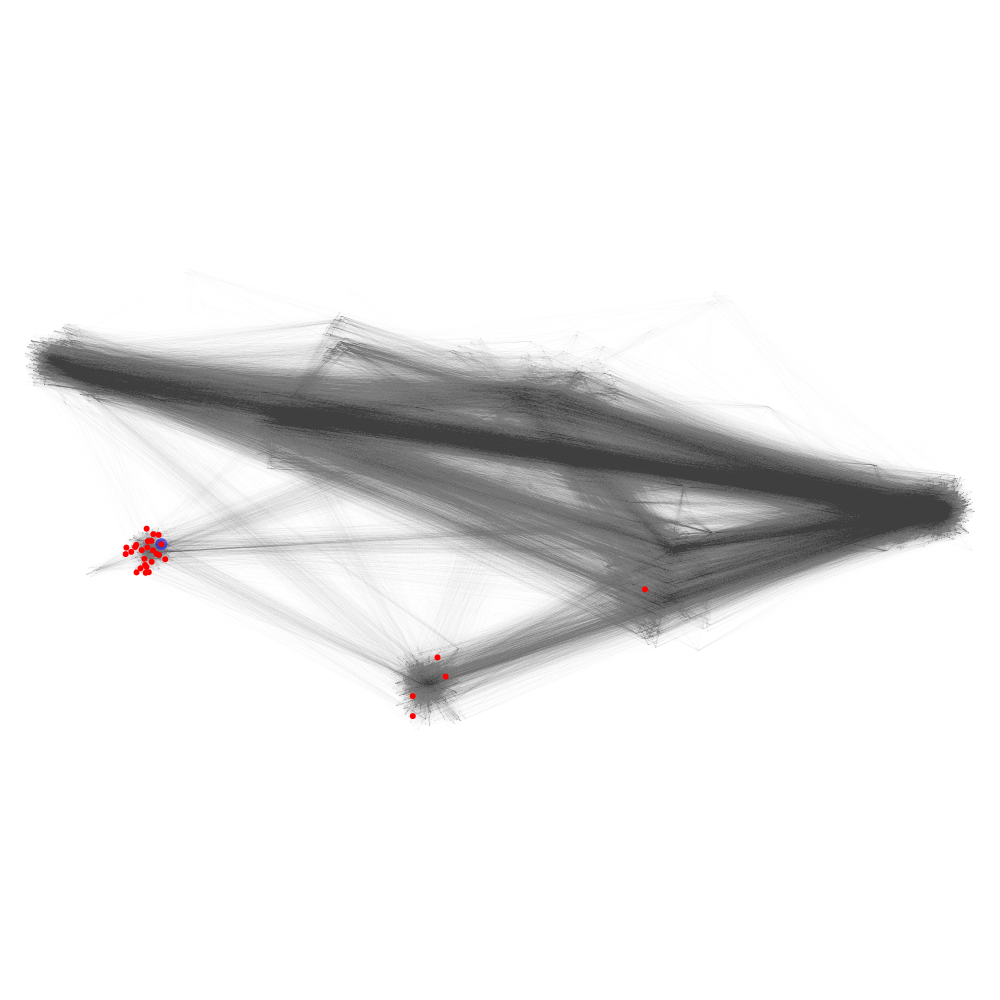

CRD iteration:  6
precision: 0.8435472242249459
recall:  0.21875292137982613
Conductance: 0.6755587599134824
Conductance ground truth: 0.2624100215013555


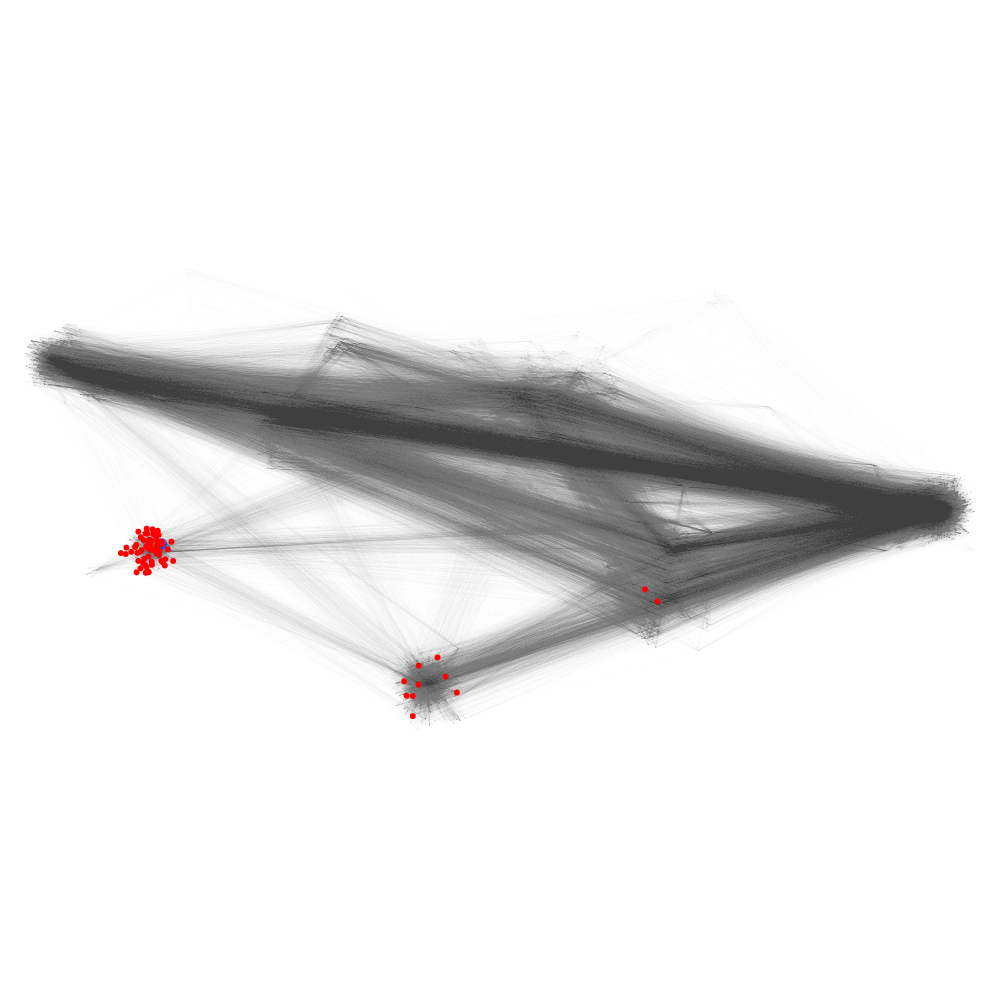

CRD iteration:  7
precision: 0.8390496263652041
recall:  0.4093671122744695
Conductance: 0.5746311553937536
Conductance ground truth: 0.2624100215013555


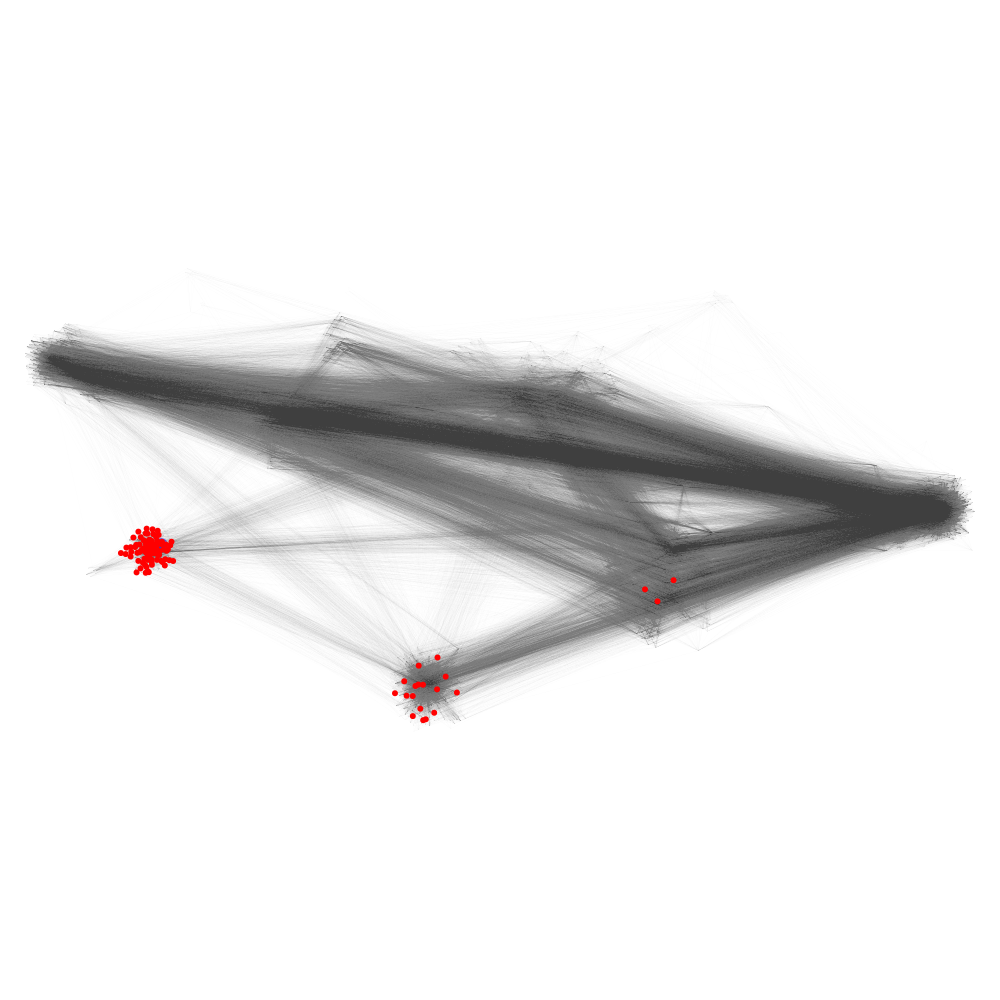

CRD iteration:  8
precision: 0.8800266184998574
recall:  0.8653828176124146
Conductance: 0.26247742180815664
Conductance ground truth: 0.2624100215013555


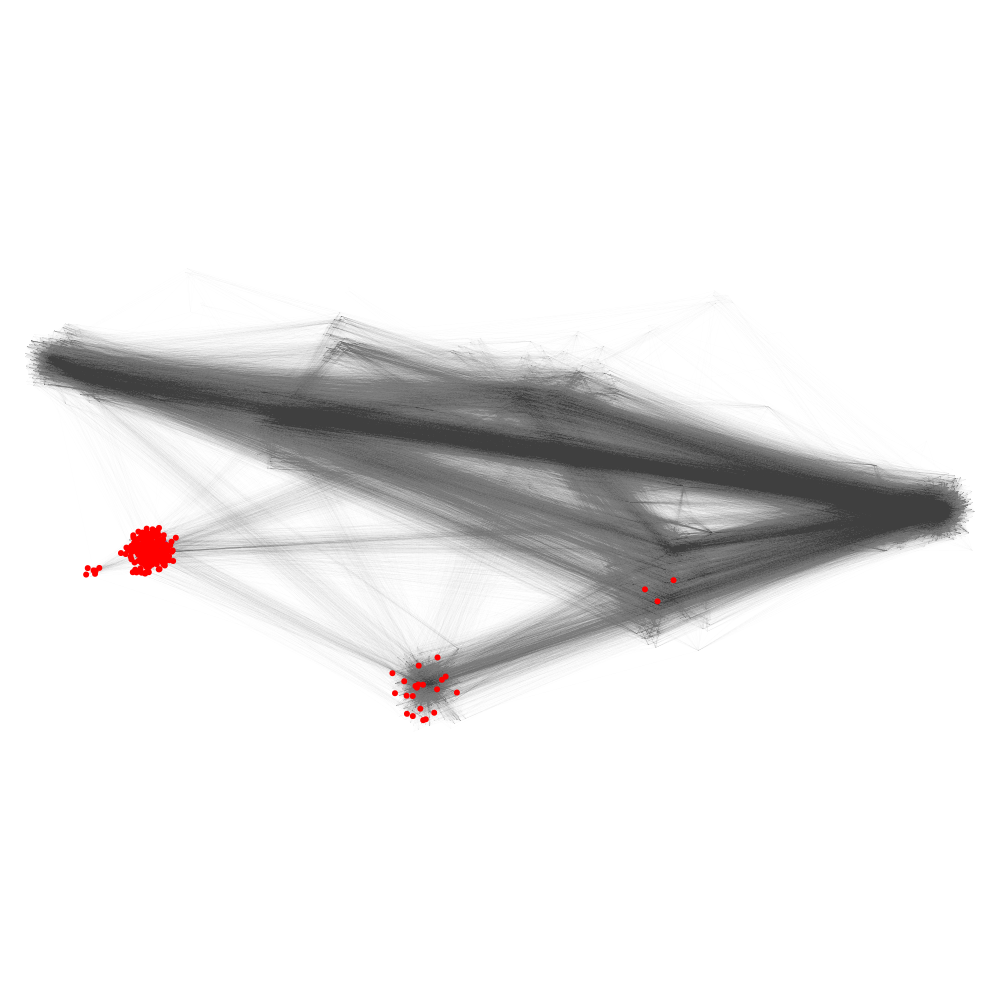

CRD iteration:  9
precision: 0.92655010814708
recall:  0.9611105917546976
Conductance: 0.1815068493150685
Conductance ground truth: 0.2624100215013555


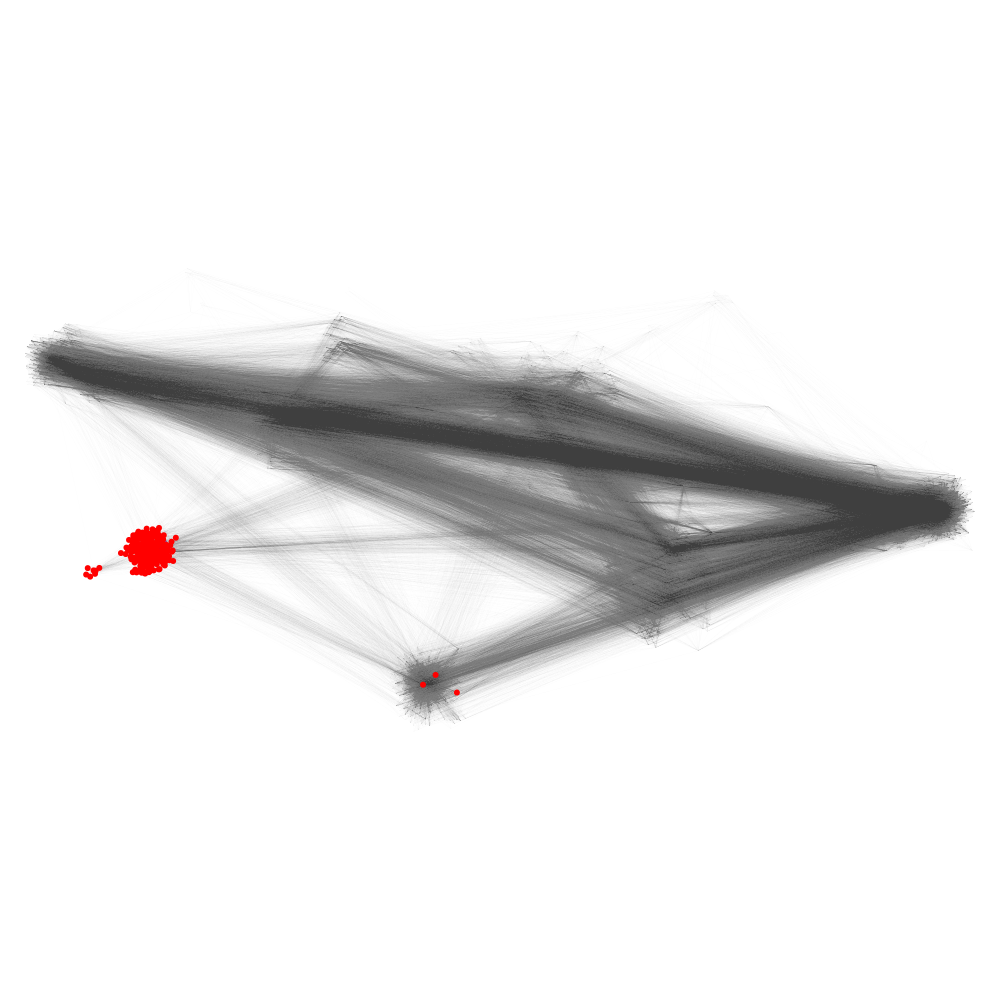

In [6]:
ref_node = [3950]

for iterations in range(9):

    # Run the algorithm
    output_crd_fast = capacity_releasing_diffusion(g,ref_node,iterations = iterations + 1)[0]
    
    # Measure accuracy
    true_positives = set(majorIndex_217_students).intersection(output_crd_fast)
    if len(true_positives) == 0:
        true_positives = set(ref_node)
        vol = g.d[ref_node]
    else:
        vol = sum(g.d[output_crd_fast])   
    precision_ex = sum(g.d[np.array(list(true_positives))])/vol
    recall_ex = sum(g.d[np.array(list(true_positives))])/sum(g.d[majorIndex_217_students])
    print("CRD iteration: ", iterations + 1)
    print("precision:", precision_ex)
    print("recall: ", recall_ex)
    print("Conductance:",g.compute_conductance(output_crd_fast))
    print("Conductance ground truth:",g.compute_conductance(majorIndex_217_students))
    
    # Visualize the results.
    temp = np.zeros(g._num_vertices) + 0.00001

    temp[output_crd_fast] = 6

    node_size = g_gtool.new_vertex_property("double",temp)

    temp = ["black" for x in range(g._num_vertices)]

    for i in output_crd_fast:
        temp[i] = "red"

    node_colours = g_gtool.new_vertex_property("string",temp)  

    halo = np.zeros(g._num_vertices, dtype=bool)
    halo[ref_node] = True
    node_halo = g_gtool.new_vertex_property("bool",halo)

    c_map = plt.get_cmap('autumn')
    
    graph_draw(g_gtool, pos, output_size=(1000, 1000),
               vertex_size=node_size, 
               vertex_fill_color=node_colours, 
               vertex_halo=node_halo,
               vertex_halo_size = 2.0,
               vorder=node_size,
               edge_pen_width=0.1,
               edge_color = [0.0, 0, 0, 0.05],
               vcmap=c_map)

# Run spectral-based method, l1-regularized PageRank

Teleportation parameter:  0.0001
precision: 0.2410211346942454
recall:  1.0
Conductance: 0.17453021495200757
Conductance ground truth: 0.2624100215013555


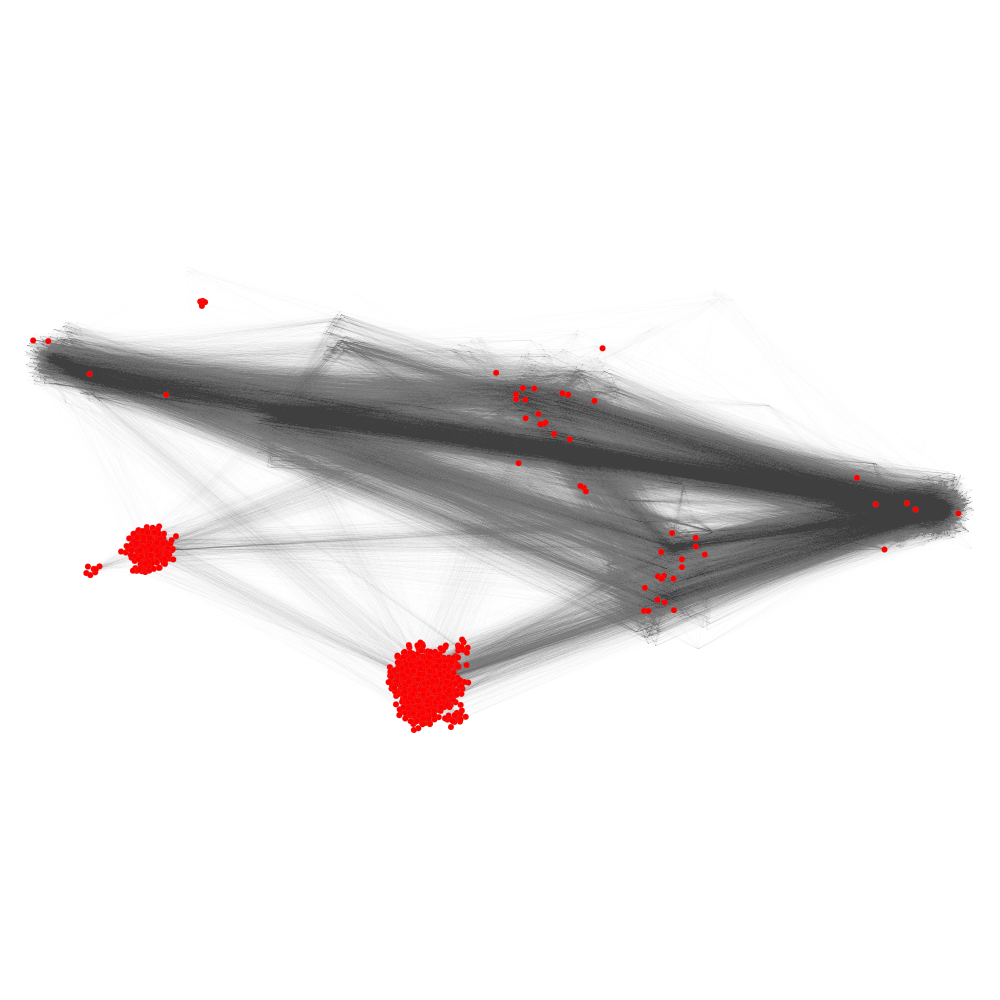

Teleportation parameter:  0.001
precision: 0.2410211346942454
recall:  1.0
Conductance: 0.17453021495200757
Conductance ground truth: 0.2624100215013555


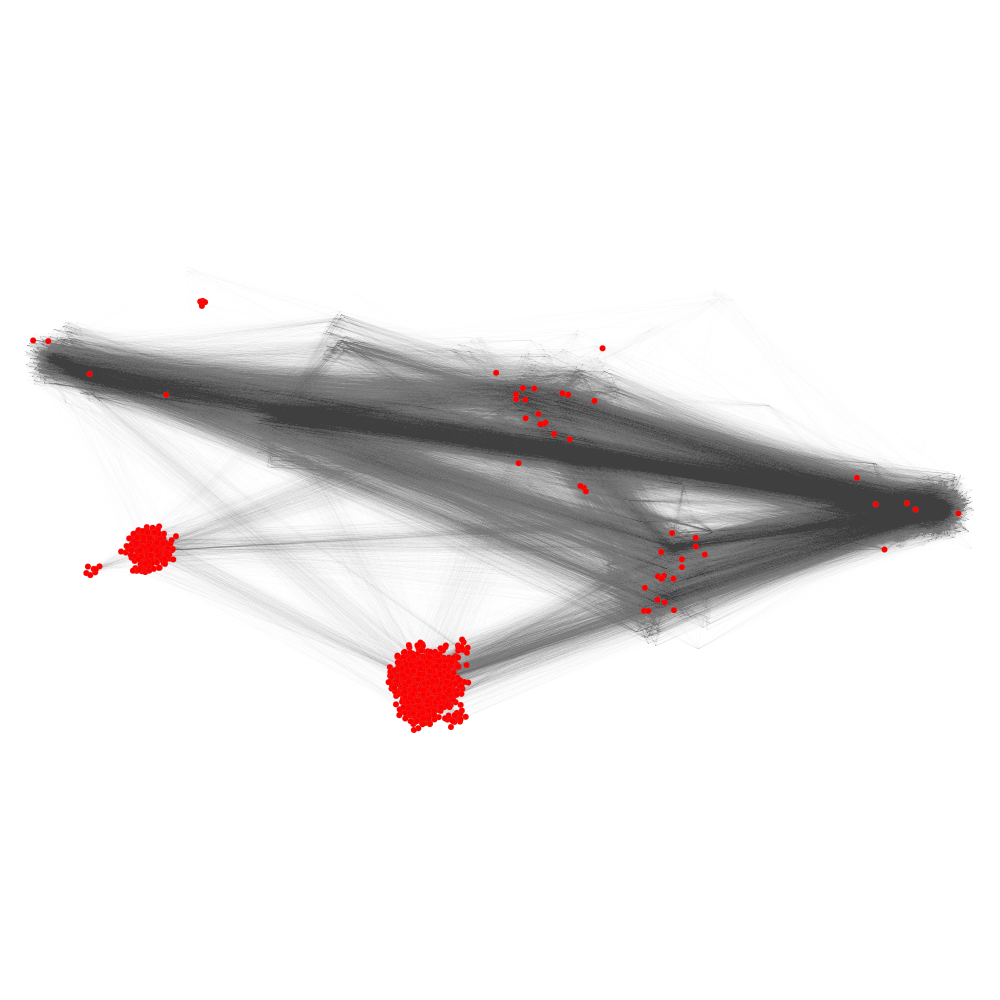

Teleportation parameter:  0.01
precision: 0.2428266594025243
recall:  1.0
Conductance: 0.17601924997729956
Conductance ground truth: 0.2624100215013555


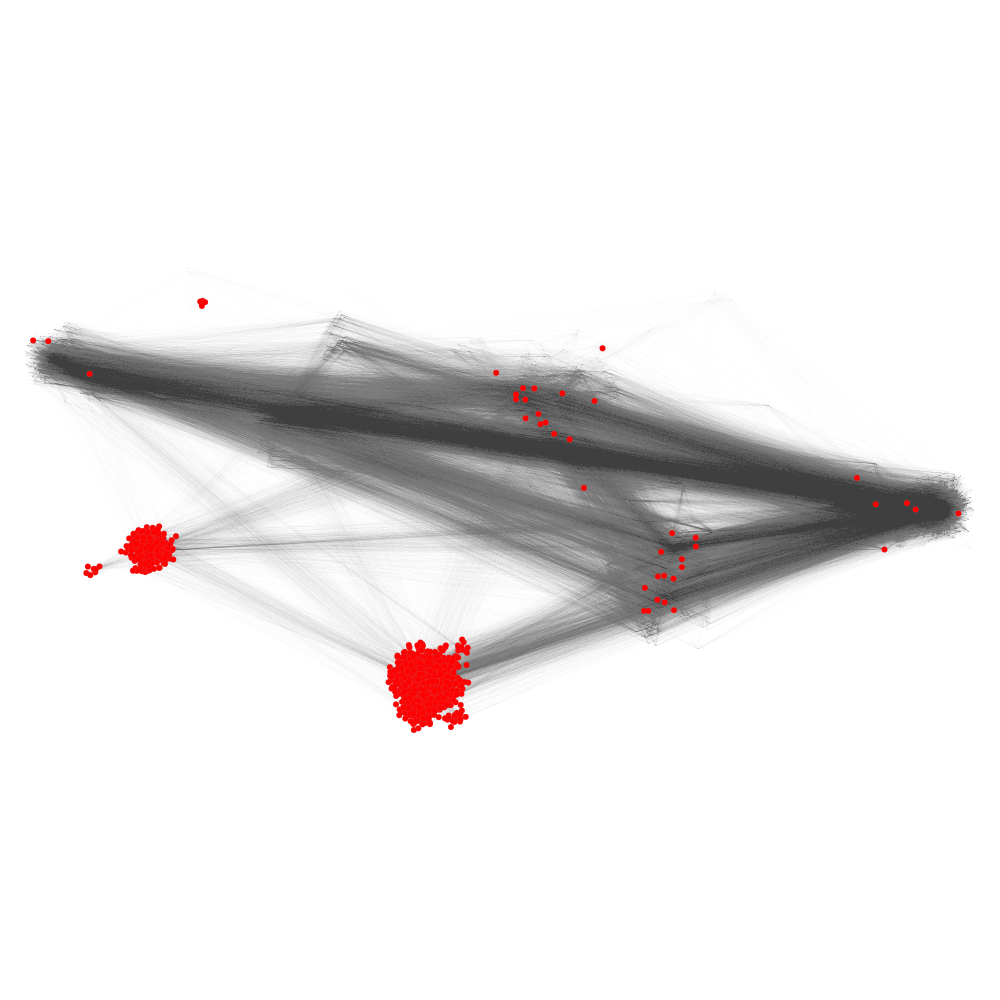

Teleportation parameter:  0.1
precision: 0.23467082026193975
recall:  1.0
Conductance: 0.19724458679770968
Conductance ground truth: 0.2624100215013555


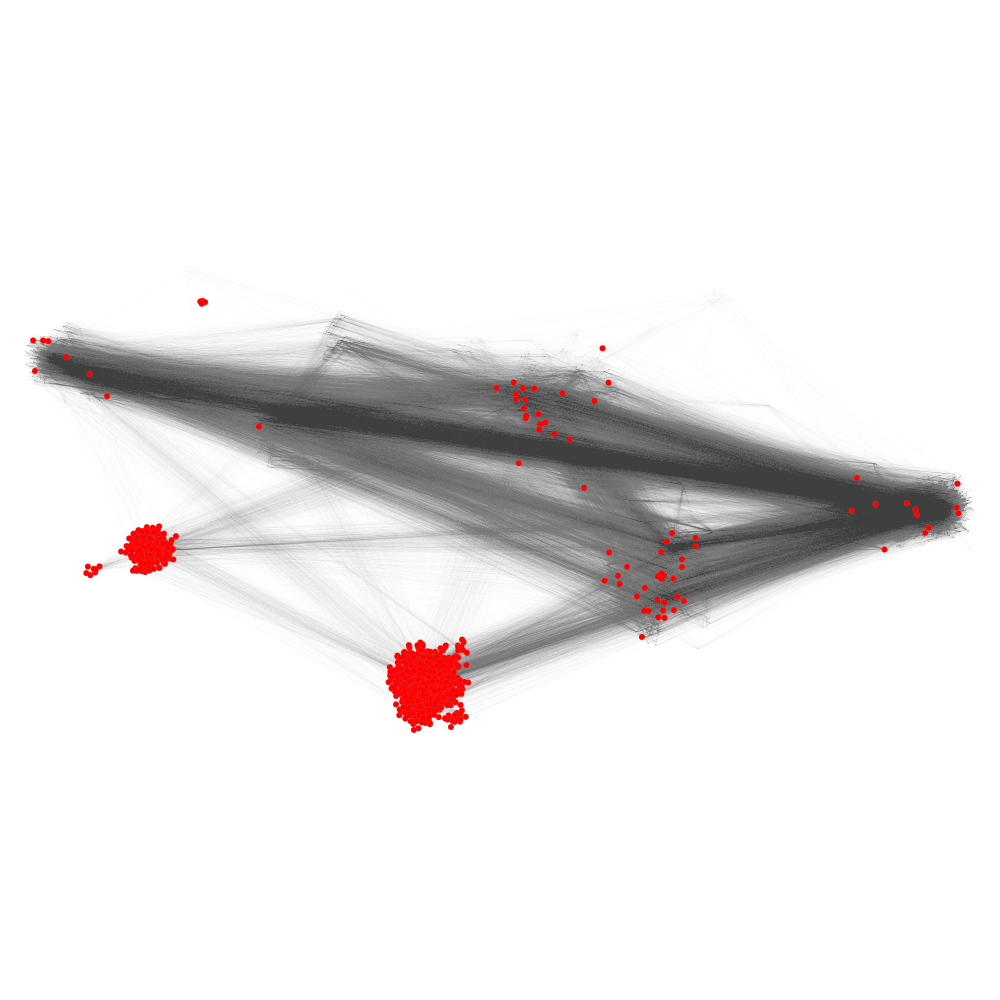

Teleportation parameter:  0.2
precision: 0.24765921943079633
recall:  0.9989716743012059
Conductance: 0.23954760359692223
Conductance ground truth: 0.2624100215013555


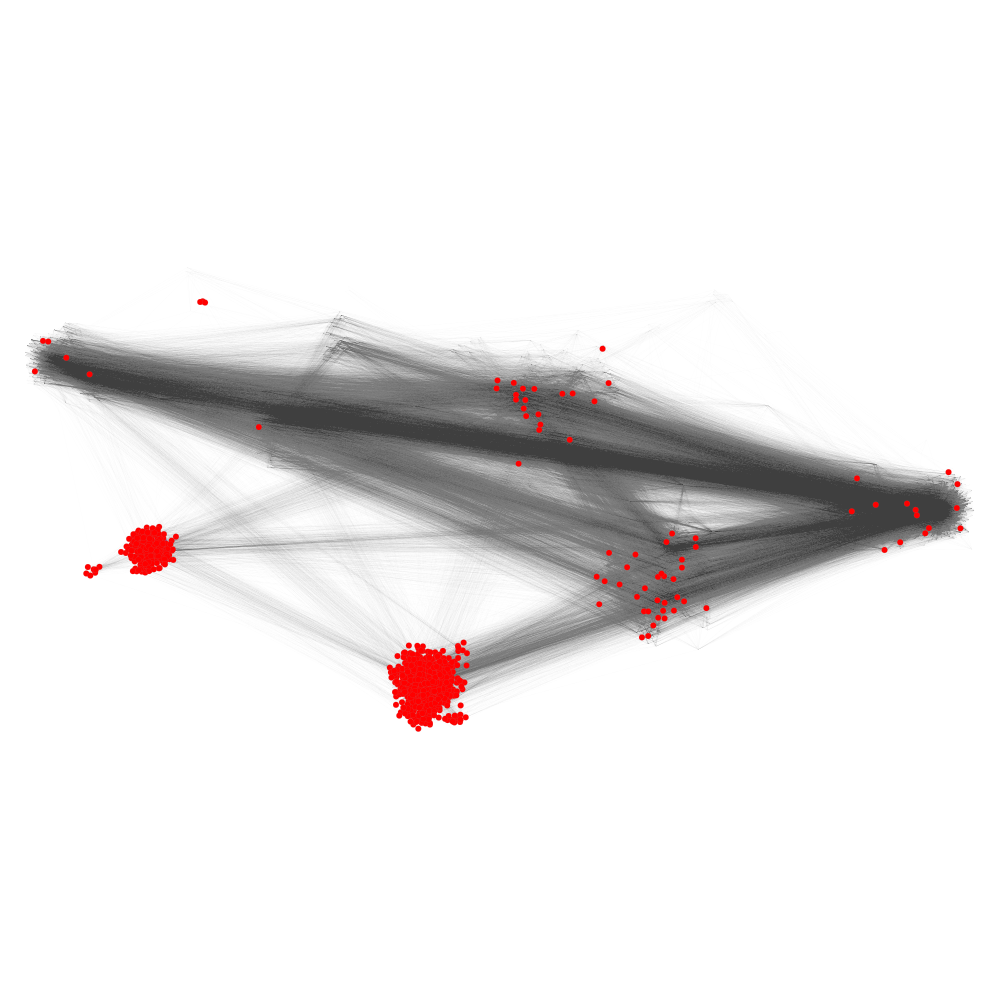

Teleportation parameter:  0.3
precision: 0.24527695521428736
recall:  0.9988781901467702
Conductance: 0.2925647912219085
Conductance ground truth: 0.2624100215013555


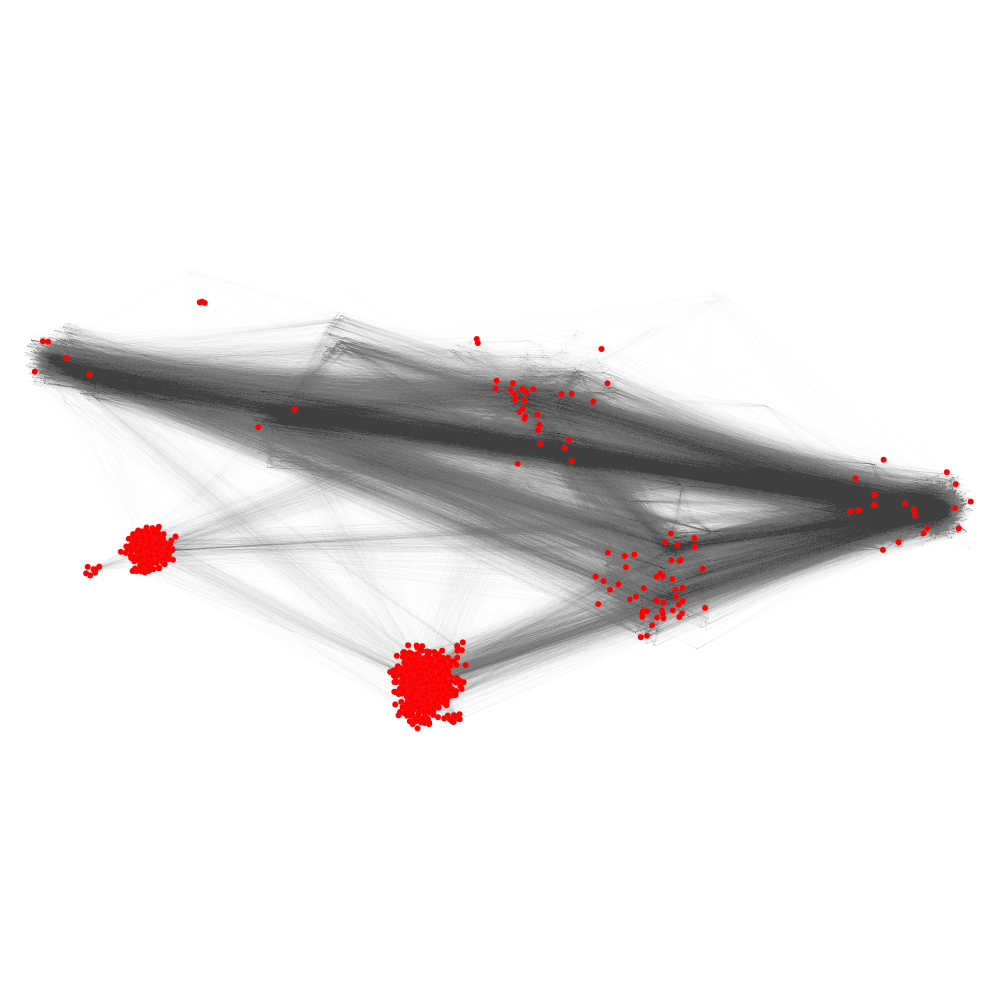

Teleportation parameter:  0.5
precision: 0.7441772534785239
recall:  0.9199775638029354
Conductance: 0.3504234724742892
Conductance ground truth: 0.2624100215013555


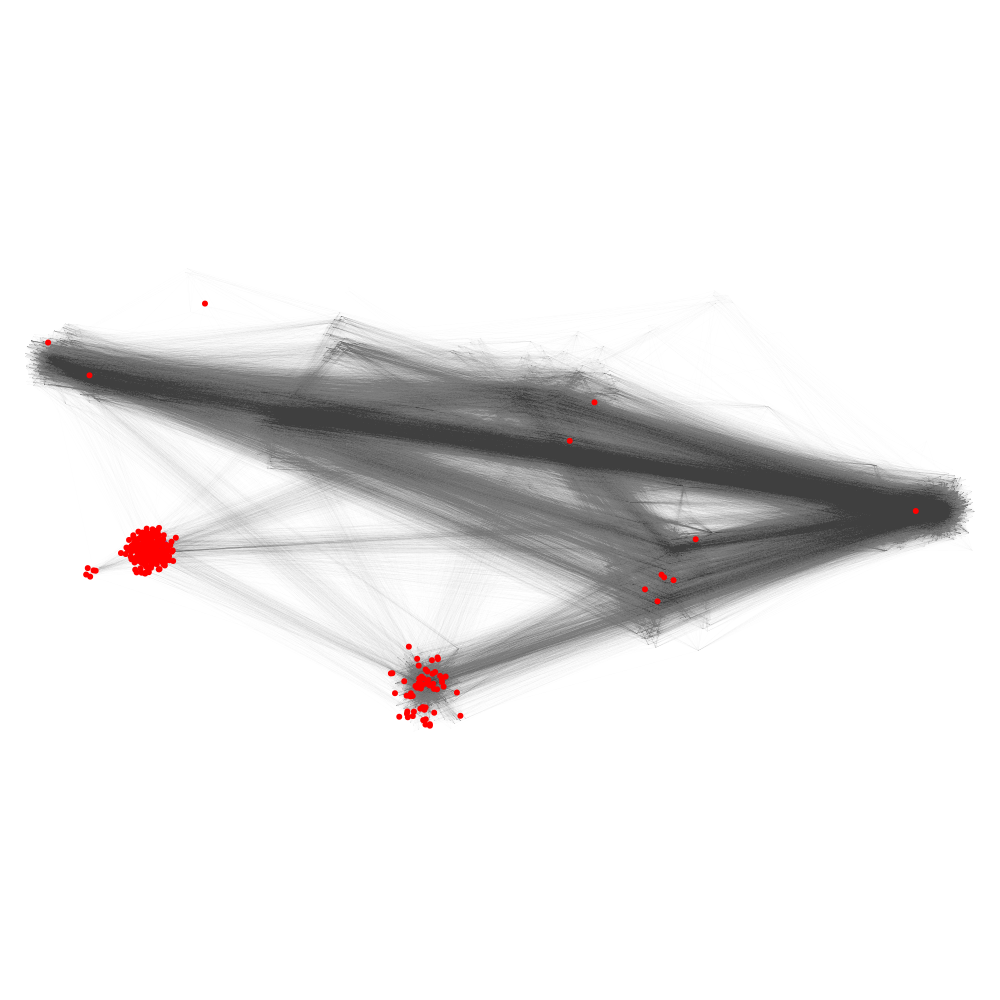

Teleportation parameter:  0.8
precision: 0.8432671081677704
recall:  0.3571094699448443
Conductance: 0.6163355408388521
Conductance ground truth: 0.2624100215013555


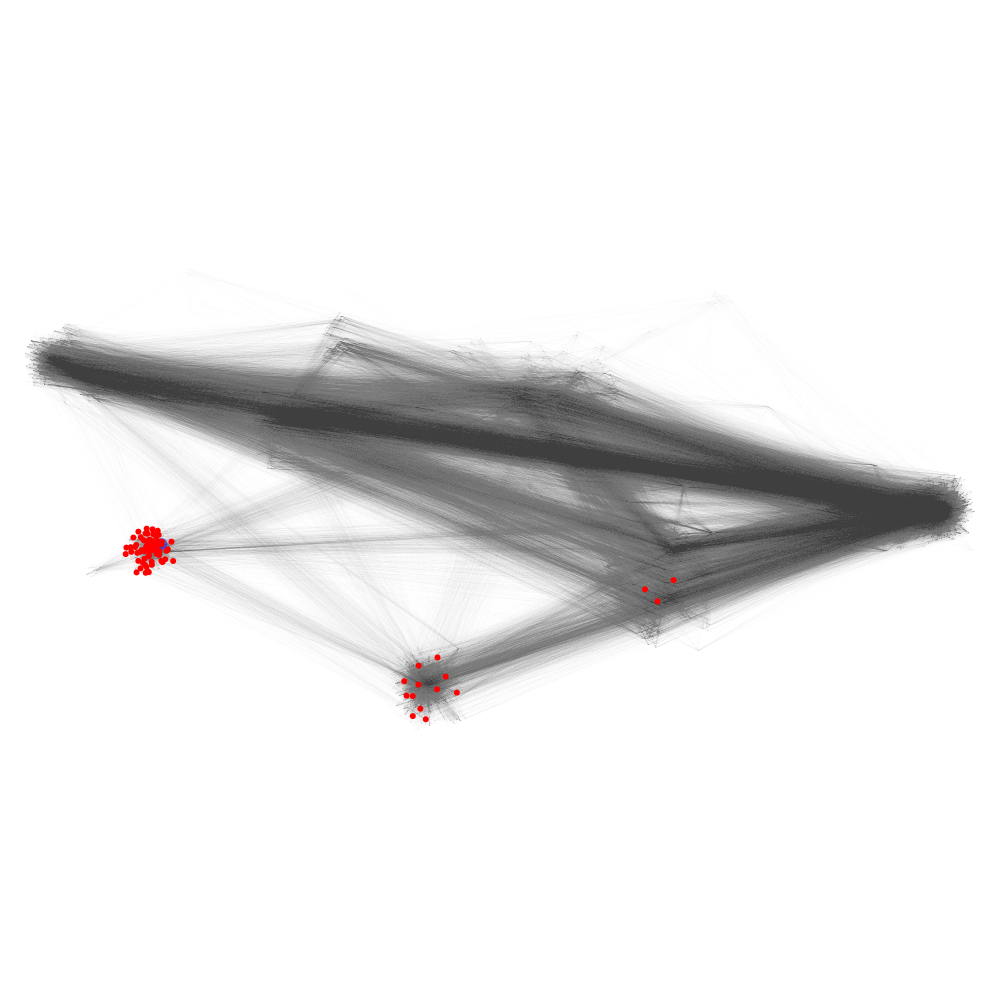

Teleportation parameter:  0.85
precision: 0.8432671081677704
recall:  0.3571094699448443
Conductance: 0.6163355408388521
Conductance ground truth: 0.2624100215013555


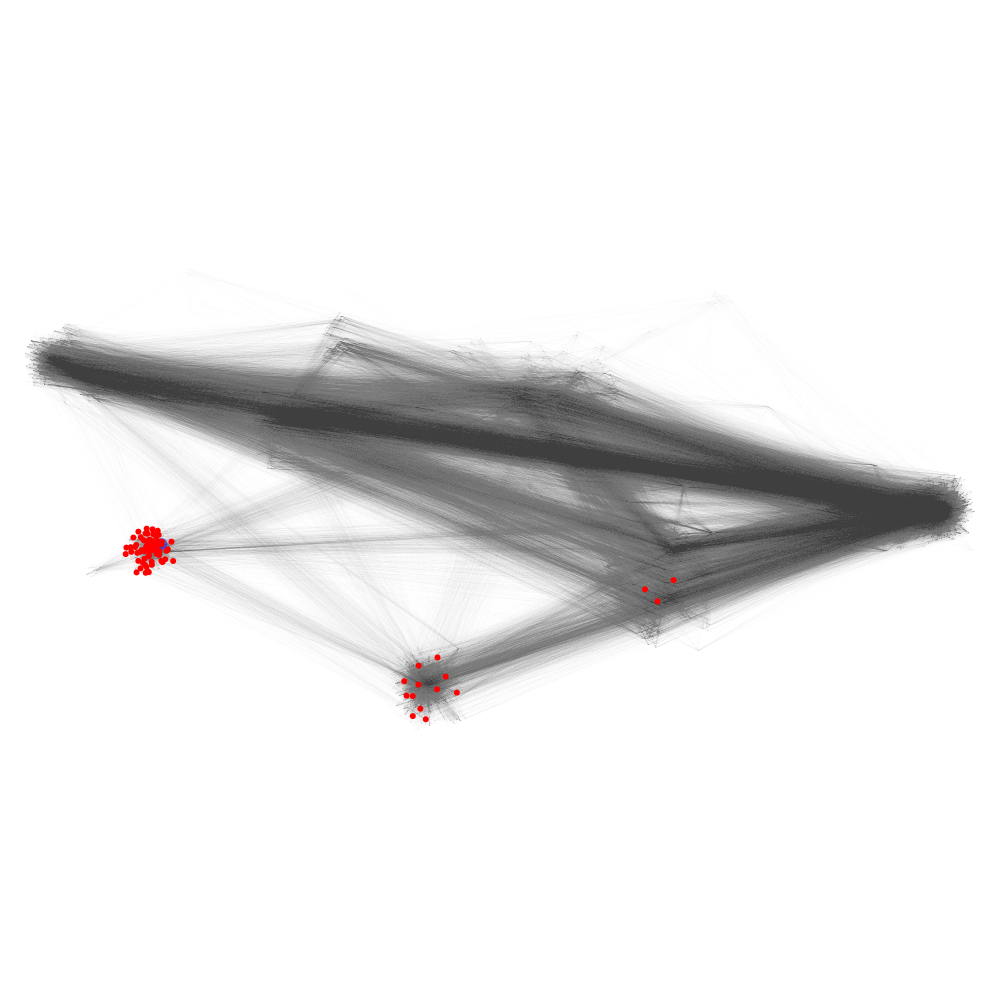

Teleportation parameter:  0.9
precision: 0.8432671081677704
recall:  0.3571094699448443
Conductance: 0.6163355408388521
Conductance ground truth: 0.2624100215013555


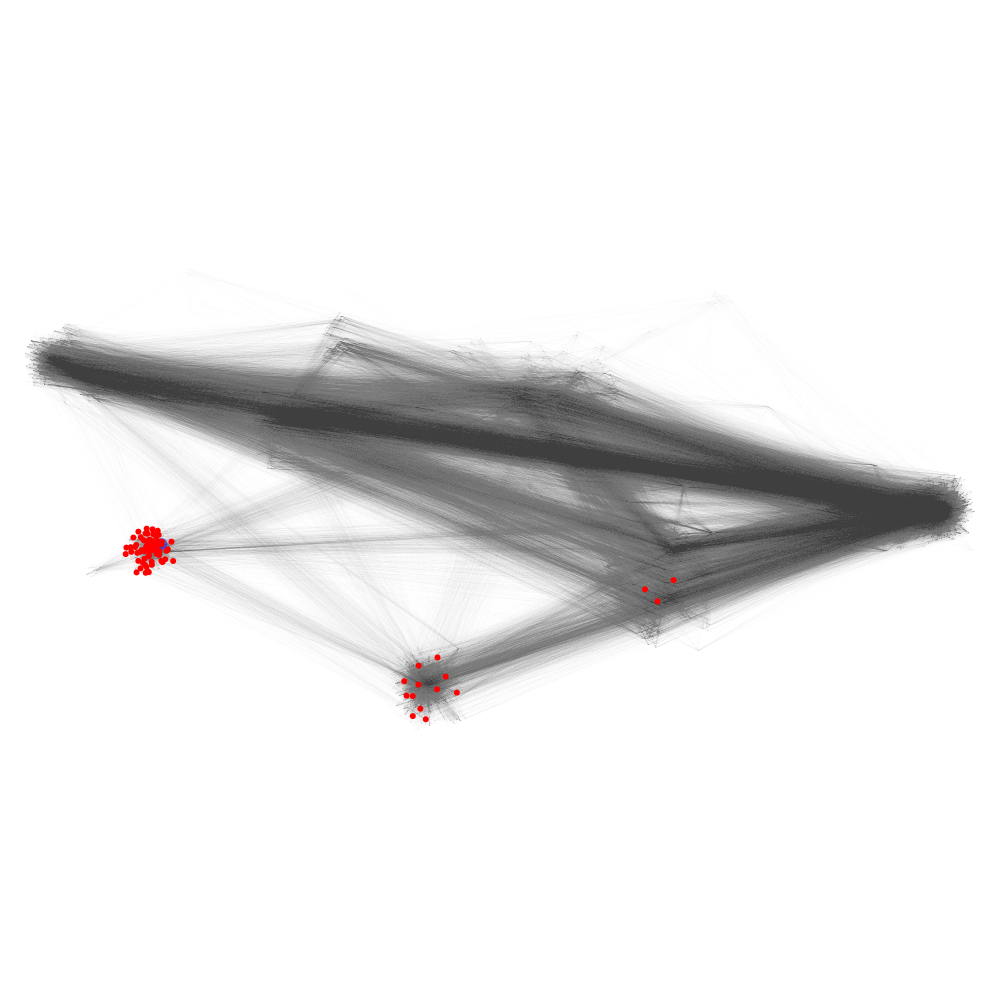

Teleportation parameter:  0.95
precision: 0.8432671081677704
recall:  0.3571094699448443
Conductance: 0.6163355408388521
Conductance ground truth: 0.2624100215013555


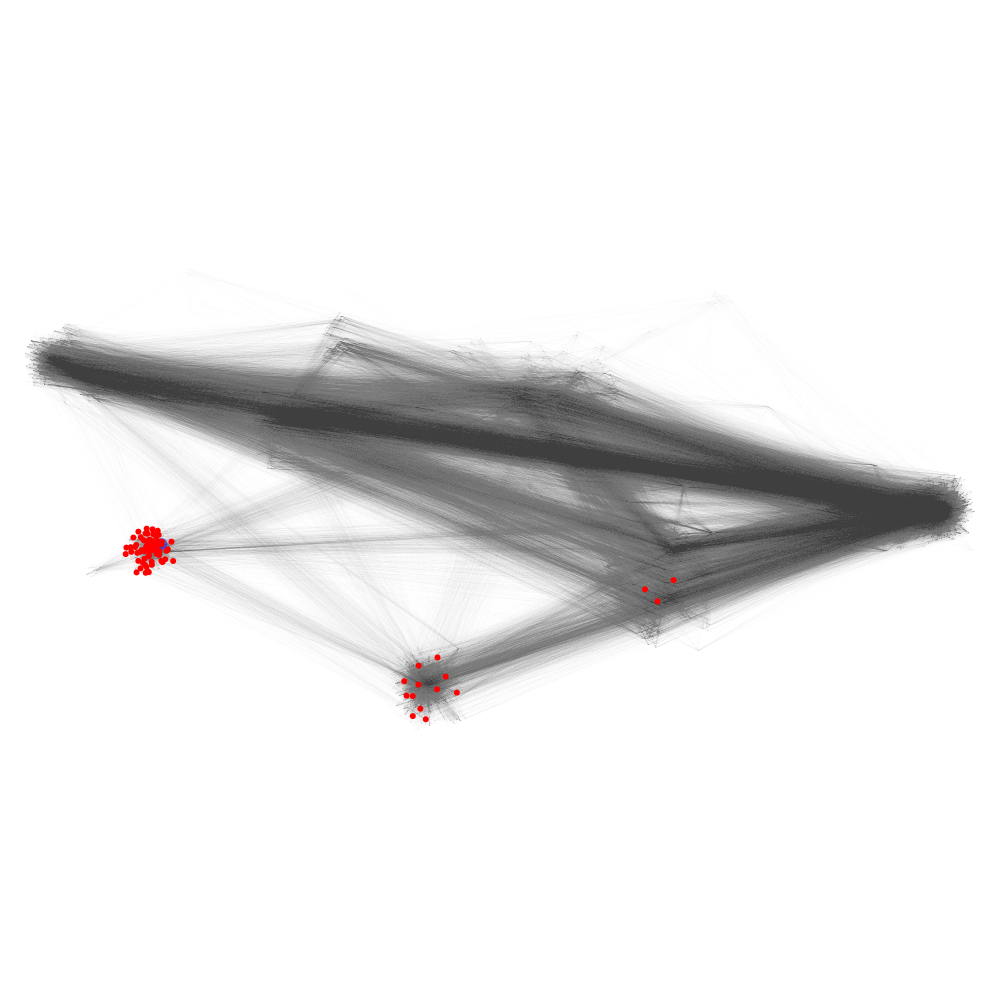

Teleportation parameter:  0.99
precision: 0.7974110032362459
recall:  0.1151724782649341
Conductance: 0.7488673139158576
Conductance ground truth: 0.2624100215013555


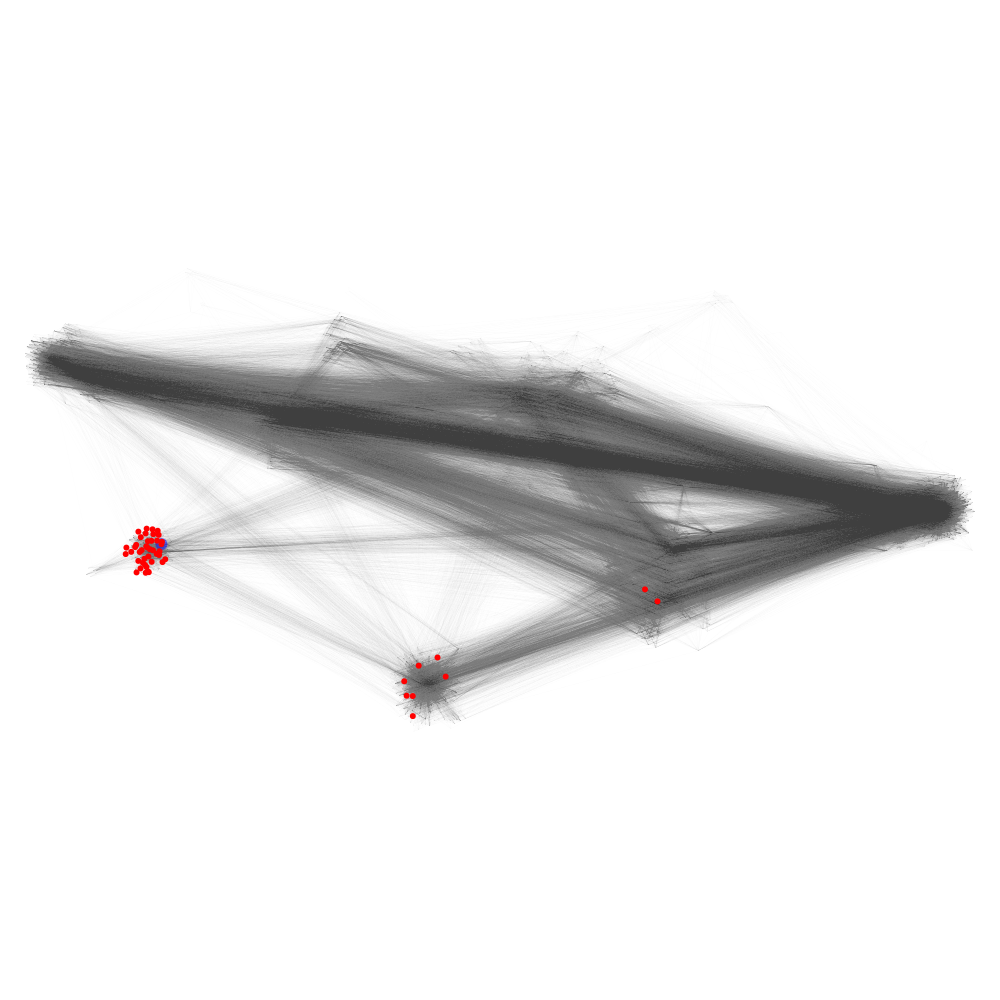

In [7]:
alphas = [1.0e-4,1.0e-3,1.0e-2,1.0e-1,2.0e-1,3.0e-1,5.0e-1,8.0e-1,8.5e-1,9.0e-1,9.5e-1,9.9e-1]

for alpha in alphas:
    
    # Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
    # This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
    l1_reg_vector = approximate_PageRank(g,ref_node,alpha = alpha,method="l1reg")
    
    # Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
    output_sc_fast = sweep_cut(g,l1_reg_vector)
    
    # Extract the partition for g and store it.
    l1_reg_vector_rounded = output_sc_fast[0]

    # Measure accuracy
    true_positives = set(majorIndex_217_students).intersection(l1_reg_vector_rounded)
    if len(true_positives) == 0:
        true_positives = set(ref_node)
        vol = g.d[ref_node]
    else:
        vol = sum(g.d[l1_reg_vector_rounded])   
    precision_ex = sum(g.d[np.array(list(true_positives))])/vol
    recall_ex = sum(g.d[np.array(list(true_positives))])/sum(g.d[majorIndex_217_students])
    print("Teleportation parameter: ", alpha)   
    print("precision:", precision_ex)
    print("recall: ", recall_ex)   
    print("Conductance:",g.compute_conductance(l1_reg_vector_rounded))
    print("Conductance ground truth:",g.compute_conductance(majorIndex_217_students))
    
    # Visualize local partition
    temp = np.zeros(g._num_vertices) + 0.00001

    temp[l1_reg_vector_rounded] = 6

    node_size = g_gtool.new_vertex_property("double",temp)

    temp = ["black" for x in range(g._num_vertices)]

    for i in l1_reg_vector_rounded:
        temp[i] = "red"

    node_colours = g_gtool.new_vertex_property("string",temp)

    halo = np.zeros(g._num_vertices, dtype=bool)
    halo[ref_node] = True
    node_halo = g_gtool.new_vertex_property("bool",halo)

    c_map = plt.get_cmap('autumn') 
    
    graph_draw(g_gtool, pos, output_size=(1000, 1000),
               vertex_size=node_size, 
               vertex_fill_color=node_colours, 
               vertex_halo=node_halo,
               vertex_halo_size = 2.0,
               vorder=node_size,
               edge_pen_width=0.1,
               edge_color = [0.0, 0, 0, 0.05],
               vcmap=c_map)